# Neural Machine Translation on Cloud TPUs

This tutorial demonstrates how to translate text using a LSTM Network from one language to another (from English to German in this case). We will work with a dataset that contains pairs of English-German phrases. Given a sequence of words in English, we train a model to predict the German equivalent in the sequence.

Note: this requires access to a TPU. In Colab: **Runtime > Change runtime type > Hardware acclerator > TPU**. 

This tutorial includes runnable code implemented using [tf.keras](https://www.tensorflow.org/programmers_guide/keras).

By Rishabh Anand (GitHub: @rish-16)

In [1]:
!rm -rf *
!wget -nc http://www.manythings.org/anki/deu-eng.zip
!rm -rf deu-eng
!unzip deu-eng.zip

--2019-12-30 07:57:44--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7612057 (7.3M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   7.26M  18.3MB/s    in 0.4s    

2019-12-30 07:57:44 (18.3 MB/s) - ‘deu-eng.zip’ saved [7612057/7612057]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [2]:
!head deu.txt

Hi.	Hallo!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)
Hi.	Grüß Gott!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)
Run!	Lauf!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)
Wow!	Potzdonner!	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)
Wow!	Donnerwetter!	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)
Fire!	Feuer!	CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #1958697 (Tamy)
Help!	Hilfe!	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #575889 (MUIRIEL)
Help!	Zu Hülf!	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #2122375 (Pfirsichbaeumchen)
Stop!	Stopp!	CC-BY 2.0 (France) Attribution: tatoeba.org #448320 (FeuDRenais) & #626467 (jakov)
Wait!	Warte!	CC-BY 2.0 (France) Attribution: tatoeba.org #1744314 (belgavox) & #2122378 (Pfirsichbaeumch

### Importing TensorFlow and other libraries

In [0]:
import string
import numpy as np
from numpy import array
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, RepeatVector, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Extracting lines from dataset and into array

Here, we can examine how the dataset is structures. The English-German dataset comprises of an English and German phrase separted by a tab `\t`

In [4]:
deu_eng = open('./deu.txt', mode='rt', encoding='utf-8')
deu_eng = deu_eng.read()
deu_eng = deu_eng.strip().split('\n')
deu_eng = [i.split('\t') for i in deu_eng]
deu_eng = array(deu_eng)
deu_eng = deu_eng[:50000, :]
print (deu_eng[:5])

[['Hi.' 'Hallo!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)']
 ['Hi.' 'Grüß Gott!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)']
 ['Run!' 'Lauf!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)']
 ['Wow!' 'Potzdonner!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)']
 ['Wow!' 'Donnerwetter!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)']]


### Removing punctuation

We will be removing punctuation from the phrases and converting them to lowercase. We will not be creating embeddings for punctuations or uppercase characters as it adds to the complexity of the NMT model

In [5]:
deu_eng[:, 0] = [s.translate((str.maketrans('', '', string.punctuation))) for s in deu_eng[:, 0]]
deu_eng[:, 1] = [s.translate((str.maketrans('', '', string.punctuation))) for s in deu_eng[:, 1]]

for i in range(len(deu_eng)):
    deu_eng[i, 0] = deu_eng[i, 0].lower()
    deu_eng[i, 1] = deu_eng[i, 1].lower()

print (deu_eng[:5])

[['hi' 'hallo'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)']
 ['hi' 'grüß gott'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)']
 ['run' 'lauf'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)']
 ['wow' 'potzdonner'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)']
 ['wow' 'donnerwetter'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)']]


### Tokenising the phrases

Tokenisation is the process of taking a sequence and chopping it up into smaller pieces called `tokens`. For example, suppose we have a sentence 

`"Bob returned home after the party"`

The tokenised sentence will return an array with the tokens:

`["Bob", "returned", "home", "after", "the", "party"]`

In this section, we will be breaking up the phrases into tokenised sequences that comprises of numbers for each unique word. For instance, the word "good" may have the value of 32 while the word "boy" may have the value of 46. Supposing the phrase is "good boy", the tokenised sequence is `[32, 46]`.

In [6]:
def tokenize(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    
    return tokenizer
    
eng_tokenizer = tokenize(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_sequence_length = 8
print ('English vocabulary size: {}'.format(eng_vocab_size))

deu_tokenizer = tokenize(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_sequence_length = 8
print ('German vocabulary size: {}'.format(deu_vocab_size))

English vocabulary size: 6361
German vocabulary size: 10597


### Convert lines into sequences as input for the NMT model

We will now be using our Tokeniser to create tokenised sequences of the original English and German phrases from our dataset.

In [0]:
def encode_sequences(tokenizer, sequence_length, lines):
    sequence = tokenizer.texts_to_sequences(lines)
    sequence = pad_sequences(sequence, sequence_length, padding="post") # 0s after the actual sequence
    return sequence

### Splitting the dataset into training and testing sets

In [8]:
train, test = train_test_split(deu_eng, test_size=.2, random_state=12)

x_train = encode_sequences(deu_tokenizer, deu_sequence_length, train[:, 1])
y_train = encode_sequences(eng_tokenizer, eng_sequence_length, train[:, 0])

x_test = encode_sequences(deu_tokenizer, deu_sequence_length, test[:, 1])
y_test = encode_sequences(eng_tokenizer, eng_sequence_length, test[:, 0])

print (x_train.shape, y_train.shape)
print (x_test.shape, x_test.shape)

(40000, 8) (40000, 8)
(10000, 8) (10000, 8)


### Training on a TPU

In order to connect to a TPU, we can follow 4 easy steps:

1. Connect to a TPU instance
2. Initialise a parallelly-distributed training `strategy`
3. Build our NMT model under the `strategy`
4. Train the model on a TPU

For more details on training on TPUs for free, feel free to check out [this](https://medium.com/@mail.rishabh.anand/tpu-training-made-easy-with-colab-3b73b920878f) article that covers the process in great detail.

### Connecting to available TPU instances

Here, we search for available instances of version 2 TPUs (the ones Google publically allocates)

In [0]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection

In [10]:
# Initialising a parallelly-distributed training strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128)

print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: 10.71.208.178:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.71.208.178:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10216869249166250727)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7451691719013928138)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 13745665702633419951)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 6017916795946422680)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/de

In [11]:
# Building our model under that strategy

in_vocab = deu_vocab_size
out_vocab = eng_vocab_size
units = 512
in_timesteps = deu_sequence_length
out_timesteps = eng_sequence_length

with strategy.scope():
    model = Sequential([
        Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True),
        LSTM(units, return_sequences=True),
        LSTM(units, return_sequences=True),
        Dense(out_vocab, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer="adam")
    model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 512)            5425664   
_________________________________________________________________
lstm (LSTM)                  (None, 8, 512)            2099200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 8, 6361)           3263193   
Total params: 12,887,257
Trainable params: 12,887,257
Non-trainable params: 0
_______________

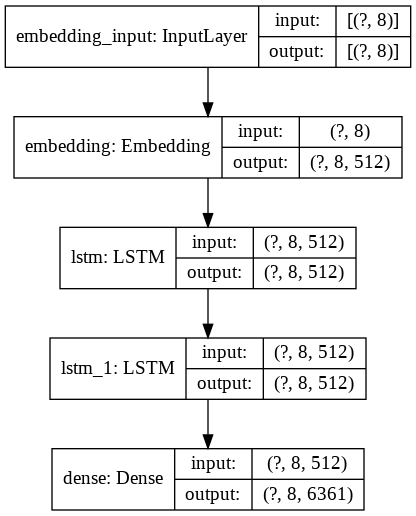

In [12]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB"
)

In [13]:
history = model.fit(x_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1), epochs=30, steps_per_epoch=1000)

Epoch 1/30
1000/1000 [==============================] - 18s 18ms/step - loss: 2.0276
Epoch 2/30
1000/1000 [==============================] - 14s 14ms/step - loss: 1.5062
Epoch 3/30
1000/1000 [==============================] - 14s 14ms/step - loss: 1.2744
Epoch 4/30
1000/1000 [==============================] - 14s 14ms/step - loss: 1.0466
Epoch 5/30
1000/1000 [==============================] - 14s 14ms/step - loss: 0.9023
Epoch 6/30
1000/1000 [==============================] - 15s 15ms/step - loss: 0.7877
Epoch 7/30
1000/1000 [==============================] - 15s 15ms/step - loss: 0.6745
Epoch 8/30
1000/1000 [==============================] - 15s 15ms/step - loss: 0.6289
Epoch 9/30
1000/1000 [==============================] - 15s 15ms/step - loss: 0.5879
Epoch 10/30
1000/1000 [==============================] - 16s 16ms/step - loss: 0.5359
Epoch 11/30
1000/1000 [==============================] - 15s 15ms/step - loss: 0.4847
Epoch 12/30
1000/1000 [==============================] - 16s 16

### Checking the loss values

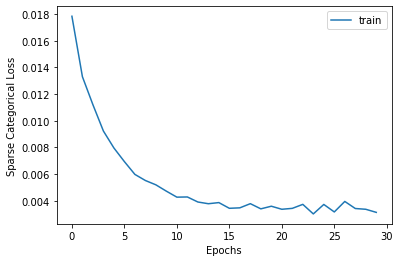

In [14]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Sparse Categorical Loss')
plt.legend(['train'])
plt.show()

### Running our model on testing dataset

In [15]:
# Getting the predictions from the testing dataset
preds = model.predict_classes(x_test.reshape(x_test.shape[0], x_test.shape[1])[:10]) # only predicting over 10 instances
print (preds)

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.
[[   3  102  159   48   48   48   48   48]
 [   2  157  331    0    0    0    0    0]
 [  24  356   40    3    0    0    0    0]
 [   1    8  112  112  112  112  112  112]
 [ 128    9   75   75   75   75   75   75]
 [   3  135  254  198  198  198  198  198]
 [   1   38    5  149  403  403  403  403]
 [  10  277   63   55  397    0    0    0]
 [  25 1518  218    0    0    0    0    0]
 [   2   35   35    7    7    7    7    7]]


In [0]:
# A function to convert a sequence back into words
def convert_words(n, tokenizer):
    for word, idx in tokenizer.word_index.items():
        if idx == n:
            return word
    return None

In [0]:
# Running our model on the testing dataset
pred_texts = []
for i in preds:
    temp = []
    for j in range(len(i)):
        word = convert_words(i[j], eng_tokenizer)
        if j > 0:
            if (word == convert_words(i[j-1], eng_tokenizer)) or (word == None):
                temp.append('')
            else:
                temp.append(word)
        else:
            if (word == None):
                temp.append('')
            else:
                temp.append(word)
                
    pred_texts.append(' '.join(temp))    

### Translating the text from German to English

We can see that our model does a relatively good job in translating the German text to English. However, there are instances that seem to have the wrong translation or are outright incorrect. Nonetheless, for a basic NMT model that was trained for 30 epochs, the model's generalisation is great.

In [18]:
pred_df = pd.DataFrame({'actual': test[:10, 0], 'prediction': pred_texts})

pred_df

,actual,prediction
0,you need to wake up,you must stay up
1,i feel old,i feel little
2,im sorry tom,its sorry for you
3,hide the money,tom the money
4,is someone calling me,call me see
5,you should work hard,you should swim hard
6,tom has a big problem,tom has a big problem
7,he lives with his mom,he lives with his mother
8,whats toms job,what animal father
9,i dont want to drive,i want to
